In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 1488
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 300
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
final = pd.read_csv("/app/_data/labels_nocall/nocall_predictions.csv")
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

In [4]:
all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)

all_audio.shape

(65128, 24)

In [5]:
_, list_filenames = choose_ids(1000, start_year=1990)
len(list_filenames)

42727

In [6]:
all_audio = all_audio.query('filename in @list_filenames').reset_index(drop=True)

# dict_birds and weights

In [7]:
all_audio = all_audio[all_audio["rating"] >= 2.5]

In [8]:
all_audio.shape

(41267, 24)

In [9]:
dict_birds, all_audio = make_dict_birds(all_audio)

In [10]:
len(dict_birds)

395

In [11]:
# os.mkdir("/app/_data/models/from_nocall/Eff2_4/")

In [12]:
file_json = open("/app/_data/models/from_nocall/Eff2_4/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [13]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

## calls

In [14]:
drop_list_final = final[(final["bird"] == 1) & (final["nocall"] == 1)][
    "row_id"
].tolist()

In [15]:
final = final.query("row_id not in @drop_list_final")
final = final.query("bird == 1")


In [16]:
final.shape

(2559079, 5)

In [17]:
final = final.merge(
    all_audio[["filename", "primary_label", "class_weights", 'duration']], on="filename", how="left"
)

In [18]:
final.isna().sum()

nocall                0
bird                  0
row_id                0
filename              0
end_sec               0
primary_label    845106
class_weights    845106
duration         845106
dtype: int64

In [19]:
final = final.dropna(axis=0)
final = final.drop(['nocall', 'bird'], axis=1)

In [20]:
final.shape

(1713973, 6)

In [21]:
final_0_20 = final[final['duration']<19]
final_20_30 = final[(final['duration']>=19)&(final['duration']<=30)]
final_30 = final[final['duration']>30]

In [22]:
final_20_30['duration'] = final_20_30['duration']-4
final_30['duration'] = final_30['duration']-7

In [23]:
final_20_30 = final_20_30[final_20_30['end_sec']<=final_20_30['duration']]
final_30 = final_30[final_30['end_sec']<=final_30['duration']]

In [24]:
final = pd.concat([final_0_20,final_20_30,final_30], axis=0, ignore_index=True)

In [25]:
final

,row_id,filename,end_sec,primary_label,class_weights,duration
0,XC11209_5_0,XC11209.ogg,5.0,acafly,0.008850,16.654156
1,XC11209_6_0,XC11209.ogg,6.0,acafly,0.008850,16.654156
2,XC11209_7_0,XC11209.ogg,7.0,acafly,0.008850,16.654156
3,XC11209_8_0,XC11209.ogg,8.0,acafly,0.008850,16.654156
4,XC11209_9_0,XC11209.ogg,9.0,acafly,0.008850,16.654156
...,...,...,...,...,...,...
1564675,XC615888_66_0,XC615888.ogg,66.0,yetvir,0.012195,70.125000
1564676,XC615888_67_0,XC615888.ogg,67.0,yetvir,0.012195,70.125000
1564677,XC615888_68_0,XC615888.ogg,68.0,yetvir,0.012195,70.125000
1564678,XC615888_69_0,XC615888.ogg,69.0,yetvir,0.012195,70.125000


In [26]:
dict_w = pd.DataFrame((1/final['filename'].value_counts()))
dict_w.columns=['weights']
dict_w['filename'] = dict_w.index

In [27]:
final = final.merge(dict_w, on='filename', how='left')

In [28]:
final_sample = final.sample(700000, weights="weights", random_state=SEED)
final_sample = final_sample.sample(400000, weights="class_weights", random_state=SEED)

In [29]:
final_sample['primary_label'].value_counts()

cubthr     2357
bncfly     2297
bulori     2270
normoc     2238
yebcha     2229
           ... 
comgol       73
gbbgul       66
sander       62
wegspa1      61
stvhum2      42
Name: primary_label, Length: 393, dtype: int64

In [30]:
final_sample['filename'].value_counts()

XC267940.ogg    48
XC529255.ogg    44
XC267935.ogg    44
XC617948.ogg    44
XC316089.ogg    43
                ..
XC331386.ogg     1
XC203142.ogg     1
XC494690.ogg     1
XC255174.ogg     1
XC375735.ogg     1
Name: filename, Length: 37323, dtype: int64

In [31]:
final_sample

,row_id,filename,end_sec,primary_label,class_weights,duration,weights
100645,XC120808_12_0,XC120808.ogg,12.0,gocfly1,0.010870,24.357031,0.050000
1536410,XC566182_61_0,XC566182.ogg,61.0,yebcha,0.004292,86.085000,0.012195
1147754,XC475992_10_0,XC475992.ogg,10.0,reshaw,0.015873,26.320281,0.045455
646537,XC601092_7_0,XC601092.ogg,7.0,daejun,0.003546,32.685000,0.038462
572691,XC241333_10_0,XC241333.ogg,10.0,coltro1,0.008333,81.405000,0.017241
...,...,...,...,...,...,...,...
1359976,XC276416_20_0,XC276416.ogg,20.0,trogna1,0.013158,27.260688,0.043478
1498386,XC187235_50_0,XC187235.ogg,50.0,wilsni1,0.016667,68.612531,0.029412
1060854,XC368259_45_0,XC368259.ogg,45.0,orbspa1,0.007576,59.469688,0.018519
493109,XC201398_32_0,XC201398.ogg,32.0,casfin,0.008772,155.421000,0.006757


In [32]:
final_sample = final_sample[
    ["row_id", "filename", "end_sec", "primary_label", "class_weights"]
].merge(
    all_audio[
        [
            "filename",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
        ]
    ],
    on="filename",
    how="left",
)

In [33]:
final_sample = final_sample.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [34]:
final_sample["primary_label"].value_counts()

cubthr     2357
bncfly     2297
bulori     2270
normoc     2238
yebcha     2229
           ... 
comgol       73
gbbgul       66
sander       62
wegspa1      61
stvhum2      42
Name: primary_label, Length: 393, dtype: int64

# nocall

In [35]:
nocall = nocall.drop_duplicates()

nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

nocall = nocall[~nocall['file_path'].str.contains('train_soundscapes')].reset_index(drop=True)

soundscapes_nocall =all_audio[all_audio['file_path'].str.contains('train_soundscapes')]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall['primary_label']=='nocall']

dict_w = (1/nocall['filename'].value_counts()).to_dict()
nocall['weights'] = nocall['filename'].replace(dict_w)

nocall_sample = nocall.sample(1200, random_state=SEED,  weights='weights')

nocall_sample['filename'].value_counts()

XC327562.ogg    15
XC293291.ogg    13
XC277582.ogg    13
XC217733.ogg    12
XC419561.ogg    12
                ..
XC132192.ogg     1
XC291092.ogg     1
XC168589.ogg     1
XC259210.ogg     1
XC187408.ogg     1
Name: filename, Length: 192, dtype: int64

In [36]:
nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            'class_weights'
        ]
    ],
    on="filename",
    how="left",
)

nocall_sample = nocall_sample[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]
soundscapes_nocall = soundscapes_nocall[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]

soundscapes_nocall['duration']=600

all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

all_nocall["label_id"] = dict_birds["nocall"]
all_nocall["secondary_labels_id"] = np.nan
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

all_nocall.isna().sum()

all_nocall['year'].describe()

filename                  0
row_id                    0
start_sec                 0
end_sec                   0
file_path                 0
duration                  0
rating                  273
year                    273
sin_month               273
cos_month               273
sin_longitude           273
cos_longitude           273
latitude                273
norm_latitude           273
class_weights           273
label_id                  0
secondary_labels_id    2729
dtype: int64

count    2456.000000
mean     2016.318404
std         4.392783
min      1990.000000
25%      2016.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

# concat

In [37]:
final_audio = (
    pd.concat(
        [final_sample, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

(402729, 19)

In [38]:
final_audio["primary_label"].value_counts().tail(20)

buwtea     239
oliwoo1    225
categr     221
tropew1    219
norsho     191
rthhum     187
whimbr     173
commer     149
hofwoo1    148
crfpar     113
runwre1    110
whcpar     106
banswa     106
lotduc     103
rudtur      92
comgol      73
gbbgul      66
sander      62
wegspa1     61
stvhum2     42
Name: primary_label, dtype: int64

#  upsampling


In [39]:
rare_birds = list(final_audio["primary_label"].value_counts().tail(20).index.values)

In [40]:
df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
    all_audio.query("primary_label ==@bird")["filename"].unique().tolist())
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array,sum_intervals=600)
    df = pd.concat([df, intervals], axis=0)

df

,end_sec,class_weights,filename
XC101288_5_0,5.00,0.045455,XC101288.ogg
XC101288_5_46,5.46,0.045455,XC101288.ogg
XC101288_5_93,5.93,0.045455,XC101288.ogg
XC101288_6_4,6.40,0.045455,XC101288.ogg
XC101288_6_87,6.87,0.045455,XC101288.ogg
...,...,...,...
XC617300_29_75,29.75,0.200000,XC617300.ogg
XC617300_29_9,29.90,0.200000,XC617300.ogg
XC617300_30_05,30.05,0.200000,XC617300.ogg
XC617300_30_2,30.20,0.200000,XC617300.ogg


In [41]:
df['filename'].unique().shape

(278,)

In [42]:
df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

In [43]:
df['primary_label'].unique().shape

(20,)

In [44]:
final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

(415507, 21)

laugul     335
flrtan1    326
orfpar     321
nrwswa     321
baleag     314
rubrob     305
bkbplo     305
amewig     300
solsan     284
grhcha1    278
bucmot2    278
rotbec     276
lobdow     268
tunswa     262
rugdov     262
greegr     259
rebsap     252
gretin1    244
gwfgoo     242
rehbar1    240
Name: primary_label, dtype: int64

In [45]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [46]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 224

In [47]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [48]:
# shutil.rmtree('/app/_data/npy/short_mels_224_uint8/', ignore_errors=True)

In [49]:
gen_train = MEL_Gen(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)

In [50]:
a = gen_train.__getitem__(0)

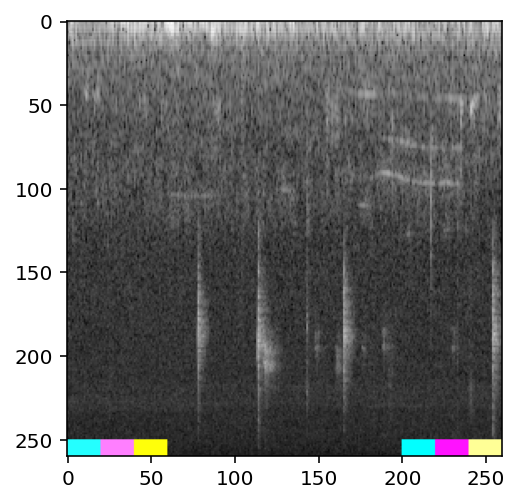

In [51]:
plt.imshow(a[0][0])

# model

In [52]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [53]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/from_nocall/Eff2_4/Eff2_4.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_4/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/from_nocall/Eff2_4/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [54]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

Epoch 10/100
   1/1483 [..............................] - ETA: 0s - loss: 0.0028 - acc: 0.9866 - recall: 0.5240 - precision: 0.9882 - f1_score: 0.8461WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1483/1483 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.9740 - recall: 0.5209 - precision: 0.9898 - f1_score: 0.8411
Epoch 00010: val_loss improved from inf to 0.00361, saving model to /app/_data/models/from_nocall/Eff2_4/Eff2_4.h5
1483/1483 [==============================] - 827s 558ms/step - loss: 0.0029 - acc: 0.9740 - recall: 0.5209 - precision: 0.9898 - f1_score: 0.8411 - val_loss: 0.0036 - val_acc: 0.9316 - val_recall: 0.4964 - val_precision: 0.9719 - val_f1_score: 0.8076
Epoch 11/100
1483/1483 [==============================] - ETA: 0s - 

ResourceExhaustedError:  OOM when allocating tensor with shape[224,131,131,96] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/functional_1/efficientnetb2/block2a_dwconv/depthwise/DepthwiseConv2dNativeBackpropInput (defined at <ipython-input-54-2f01e9ec22f2>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_43833]

Function call stack:
train_function
